In [1]:
import os as os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
from sympy import *
from random import randrange
import keras
import time
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error as mse

In [2]:
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, BatchNormalization, Input, Dense, Dropout, Reshape, Flatten, Add, Lambda, \
    LSTM, GRU, Conv1D, Concatenate, BatchNormalization, TimeDistributed, RepeatVector, Activation
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.train import Checkpoint

In [3]:
#Generate solution for given initial conditions
def solver(nx=40,nt=99,x_len=1,t_len=0.2,plot=True ):
  
    #  Set parameters.
    nx = nx
    nt = nt
    x_length = x_len
    t_length = t_len
    g = 9.8
    
    #  Compute H and UH.
    
    h = np.zeros ( nx )
    uh = np.zeros ( nx )
    hm = np.zeros ( nx - 1 )
    uhm = np.zeros ( nx - 1 )
    x = np.zeros ( nx )
    t = np.zeros ( nt + 1 )
    h_array = np.zeros ( [ nx, nt + 1 ] )
    uh_array = np.zeros ( [ nx, nt + 1 ] )
    #
    #  Define the locations of the nodes and time steps and the spacing.
    #
    x = np.linspace ( 0, x_length, nx )
    t = np.linspace ( 0, t_length, nt + 1 )

    dx = x_length / float ( nx - 1 )
    dt = t_length / float ( nt )
    #  Apply the initial conditions.
    h = initial_conditions ( nx, x )
    uh=np.zeros(nx)
    
    #  Apply the boundary conditions.
    h[0] = h[nx-2]
    h[nx-1] = h[1]
    uh[0] = uh[nx-2]
    uh[nx-1] = uh[1]
    
   

    h_array[0:nx,0] = h[0:nx]
    uh_array[0:nx,0] = uh[0:nx]
    
    #  Take NT more time steps.
    for it in range ( 1, nt + 1 ):
    
    #  Take a half time step, estimating H and UH at the NX-1 spatial midpoints.
        hm[0:nx-1] = ( h[0:nx-1] + h[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( uh[1:nx] - uh[0:nx-1] ) / dx

        uhm[0:nx-1] = ( uh[0:nx-1] + uh[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( \
            uh[1:nx] ** 2    / h[1:nx]   + 0.5 * g * h[1:nx] ** 2 \
          - uh[0:nx-1] ** 2  / h[0:nx-1] - 0.5 * g * h[0:nx-1] ** 2 ) / dx
        
        #  Take a full time step, evaluating the derivative at the half time step,
        #  to estimate the solution at the NX-2 nodes.
      
        h[1:nx-1] = h[1:nx-1] \
          - dt * ( uhm[1:nx-1] - uhm[0:nx-2] ) / dx

        uh[1:nx-1] = uh[1:nx-1] \
          - dt * ( \
            uhm[1:nx-1] ** 2  / hm[1:nx-1] + 0.5 * g * hm[1:nx-1] ** 2 \
          - uhm[0:nx-2] ** 2  / hm[0:nx-2] - 0.5 * g * hm[0:nx-2] ** 2 ) / dx
        
        #  Update the boundary conditions.
        
        h[0] = h[nx-2]
        h[nx-1] = h[1]
        uh[0] = uh[nx-2]
        uh[nx-1] = uh[1]

        #  Copy data into the big arrays.

        h_array[0:nx,it] = h[0:nx]
        uh_array[0:nx,it] = uh[0:nx]

    x_min = min ( x )
    x_max = max ( x )

    h_min = 0.0
    h_max = np.amax ( h_array )

    uh_max = np.amax ( uh_array )
    uh_min = np.amin ( uh_array )
    
    if plot == True:
      #  Animation of H.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, h_array[:,it] )
              title_string = ( 'H(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'H(X,T)' )
              plt.show ( block = False )
          
      #  Animation of UH.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, uh_array[:,it] )
              title_string = ( 'UH(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'UH(X,T)' )
              plt.show ( block = False )
   
      print ( 'Normal end of execution.' )

    return h_array, uh_array, x, t


In [4]:
#Random ICs
def initial_conditions ( nx, x ):

    H0=10
    x_max= np.amax(x)
    bumps=randrange(2,10)
    amp = np.random.rand(bumps)* (0.05*H0)
    pos = np.random.rand(bumps)*(0.75*x_max) + (0.125*x_max)
    Dissapation = 250

    Gaussian = H0*np.ones(nx)
    for i in range(len(amp)):
      if i%2 == 0:
        Gaussian += amp[i]*np.exp(-Dissapation*(x-pos[i])**2)

      elif i%2 != 0:
        Gaussian -= amp[i]*0.5*np.exp(-Dissapation*(x-pos[i])**2)
    
    h =  Gaussian
    return h
#Take only every n step in time and space
def prep_data(h,u,x,t,n):
    
    h= np.transpose(h[::n,::n])
    u= np.transpose(u[::n,::n])
    x=x[::n]
    t=t[::n]
    
    X_h= []#np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    y_h=[]  # np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    X_u=[] #np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    y_u=[]  # np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    for i in range(0,len(h)-1):
        X_h.append(periodic(h[i],1/4))
        y_h.append(periodic(h[i+1],1/4))
    
    for i in range(0,len(u)-1):
        X_u.append(periodic(u[i],1/4))
        y_u.append(periodic(u[i+1],1/4))

    t=t[:-1]
    x1=  extend_domain(x,1/4)
    return X_h, y_h, X_u, y_u, x1, t

#Merge several data sets with different ICs into one set of data for generality
def generate_data (rounds,nx,x_length,t_length):

  nt=nx-1
  h_array, uh_array, x, t   = solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)
  X_h, y_h, X_u, y_u, x, t = prep_data(h_array, uh_array, x, t,n=4)

  for i in range(rounds -1):
    h_array, uh_array, x, t=solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)
    training_hTemp, labels_hTemp, training_uTemp, labels_uTemp, x, t= prep_data(h_array, uh_array, x, t,n=4)

    X_h =np.concatenate((X_h,training_hTemp),axis=0)
    y_h= np.concatenate((y_h,labels_hTemp),axis=0)
    X_u=np.concatenate((X_u,training_uTemp),axis=0)
    y_u=np.concatenate((y_u,labels_uTemp),axis=0)
 
  return X_h,y_h, X_u, y_u ,x,t

def normalize(data):
  min = np.amin(data)
  max = np.amax(data)
  data = (data-min)/(max-min)
  return data 

def standardize(data):
  μ = np.mean(data)
  std = np.std(data)
  data = (data-μ)/std
  return data

def generate_zeros(nodes):
  l=[[0]]
  l=l*nodes
  l=np.array(l)
  l=np.transpose(l)
  return l

  
def prep_multi_step(array,p):
  new= []
  for i in range(0,len(array),p):
    step = array[i:p+i]
    new.append(step)
    
  return np.array(new)

In [5]:
def reshape_data(X_h,y_h, X_u, y_u ,x,t):
  m1=[[],[]]
  m2=[[],[]]
  a1=[]
  a2=[]
  for i in range(len(X_h)):
    m1[0]= X_h[i]
    m1[1]= X_u[i]
    m1= np.transpose(np.array(m1))
    a1.append(m1)
    m1=[[],[]]

    m2[0]= y_h[i]
    m2[1]= y_u[i]
    m2= np.transpose(np.array(m2))
    a2.append(m2)
    m2=[[],[]]

  return np.array([a1,a2])

def periodic(array,scale=1/4):
  points= len(array)
  index= int(points*scale)
  before= array[-index:]
  after= array[0:index]
  array=np.concatenate((before,array))
  array=np.concatenate((array,after))

  return array

def extend_domain(x,scale=1/4):
  xmax= max(x)
  extend= xmax*scale
  points= int(len(x)*(1+2*scale))
  x1=np.linspace(-extend,xmax+extend,points)
  return x1



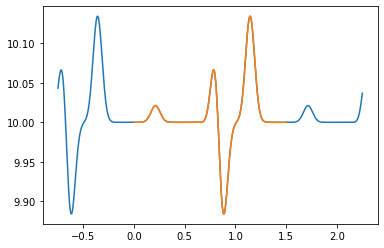

In [6]:
x=np.linspace(0,1.5,256)
IC=initial_conditions(256,x)
scale=1/2
IC1= periodic(IC,scale)


xmax= max(x)
extend= max(x)*scale
domain= int(len(x)*(1+2*scale))
x1=np.linspace(-extend,xmax+extend,domain)

plt.plot(x1,IC1)
plt.plot(x,IC)

In [7]:
def main_data(rounds,nx,x_len):

  nx=nx
  nt= 2*nx -1
  x_len= x_len
  t_len= x_len/15

  X_h,y_h, X_u, y_u,x,t  = generate_data (rounds,nx,x_len,t_len)
  Xy= reshape_data(X_h,y_h, X_u, y_u,x,t)
  n= len(X_h)
  split=int(n*0.8)
  train=Xy[:,:split]
  test= Xy[:,:int(n-split)]

  train=normalize(train)
  test=normalize(test)
  
  return train,test,x,t


In [8]:
nodes=384

In [9]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv1D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [10]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv1DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [11]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[nodes,2])

  down_stack = [
    downsample(nodes/4, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(nodes/2, 4), # (bs, 64, 64, 128)
    downsample(nodes, 4), # (bs, 32, 32, 256)
    downsample(nodes*2, 4), # (bs, 16, 16, 512)
    downsample(nodes*2, 4), # (bs, 8, 8, 512)
    downsample(nodes*2, 4), # (bs, 4, 4, 512)
    #downsample(nodes*2, 4), # (bs, 2, 2, 512)
    #downsample(nodes*2, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(nodes*2, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    #upsample(nodes*2, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    #upsample(nodes*2, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(nodes*2, 4), # (bs, 16, 16, 1024)
    upsample(nodes, 4), # (bs, 32, 32, 512)
    upsample(nodes/2, 4), # (bs, 64, 64, 256)
    upsample(nodes/4, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv1DTranspose(2, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

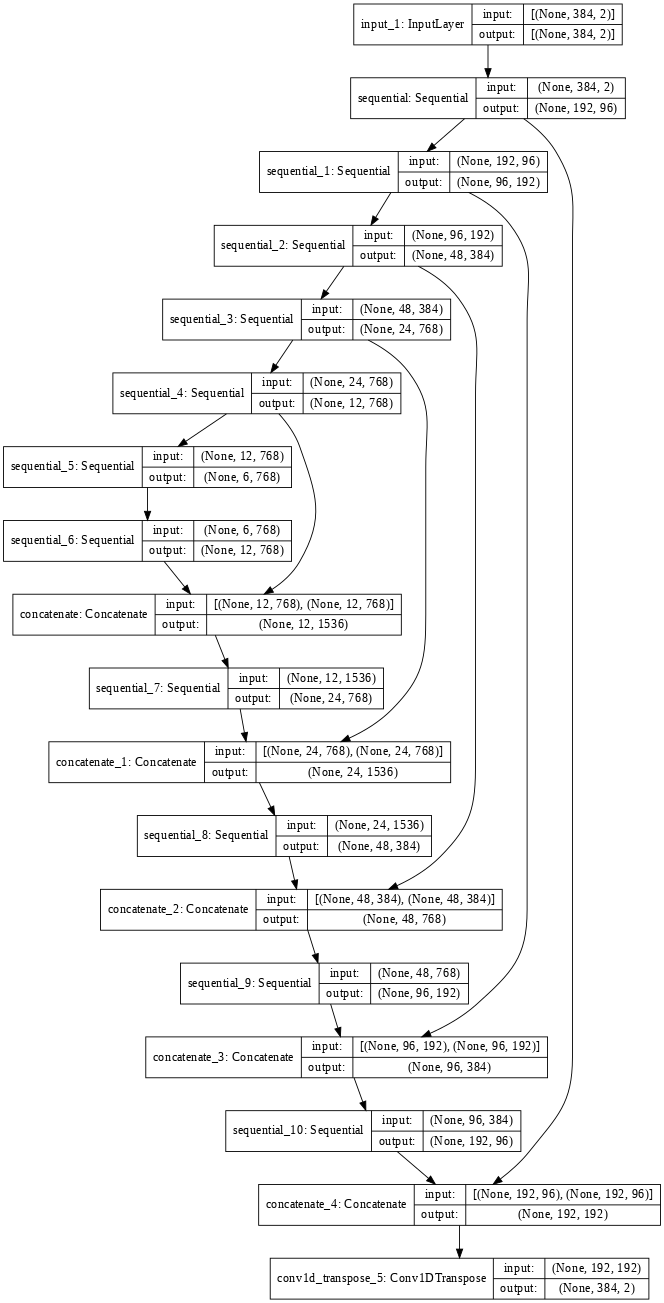

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
#generator.summary()

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[nodes, 2], name='input_image')
  tar = tf.keras.layers.Input(shape=[nodes, 2], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(nodes/4, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(nodes/2, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(nodes, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding1D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv1D(nodes*2, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding1D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv1D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

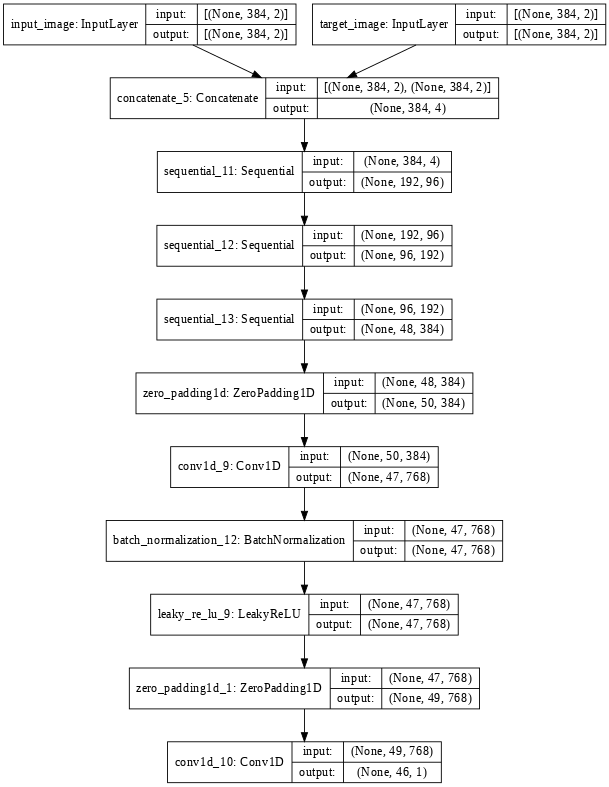

In [ ]:
discriminator = Discriminator()
#discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
from tensorflow.summary import SummaryWriter

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  #with SummaryWriter.as_default(step=None):
  tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
  tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
  tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
  tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
  gen_loss=[]
  disc_loss=[]
  for epoch in range(epochs):
    start = time.time()

    X=train_ds[0]
    y=train_ds[1]
    X= X.astype('float32')
    y=y.astype('float32')
    for i in range(len(X)):
      input_img= X[i]
      input_img= input_img[None, :] 
      target= y[i]
      target= target[None,:]
      
      train_step(input_img, target, epoch)
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [ ]:
train,test,x,t= main_data(24,1024,1.5)

In [ ]:
hist=fit(train,16,test)

Time taken for epoch 1 is 134.58317732810974 sec

Time taken for epoch 2 is 100.77883410453796 sec

Time taken for epoch 3 is 101.35605764389038 sec

Time taken for epoch 4 is 101.6332757472992 sec

Time taken for epoch 5 is 101.76614141464233 sec

Time taken for epoch 6 is 100.97942686080933 sec

Time taken for epoch 7 is 102.18225049972534 sec

Time taken for epoch 8 is 101.72114896774292 sec

Time taken for epoch 9 is 101.82572531700134 sec

Time taken for epoch 10 is 101.70394587516785 sec

Time taken for epoch 11 is 102.25294876098633 sec

Time taken for epoch 12 is 101.65238952636719 sec

Time taken for epoch 13 is 101.78342485427856 sec

Time taken for epoch 14 is 103.07038474082947 sec

Time taken for epoch 15 is 102.24146699905396 sec

Time taken for epoch 16 is 102.38186025619507 sec



In [ ]:
i=3
#def plot(i=10):
X=test[0]
y=test[1]
inp=X[i]
tar=y[i]
inp=inp[None, :]
tar=tar[None, :]

prediction = generator(inp, training=True)

predh=np.array(prediction[0,:,0])
predu=np.array(prediction[0,:,1])
tarh= tar[0,:,0]
taru= tar[0,:,1]

def post(predh, predu, tarh ,taru,x,p):
  x1=x[p:-p]
  predh=predh[p:-p]
  predu=predu[p:-p]
  tarh=tarh[p:-p]
  taru=taru[p:-p]

  diffh = np.mean(tarh)-np.mean(predh)
  diffu= np.mean(taru)-np.mean(predu)

  predh= predh + diffh
  predu= predu + diffu

  savgh= savgol_filter(predh,window_length=29,polyorder=3)
  savgu= savgol_filter(predu,window_length=29,polyorder=3)

  return x1, tarh, taru, predh, predu, savgh,savgu

In [ ]:
x1, tarh, taru, predh, predu, savgh,savgu=post(predh,predu,tarh,taru,x,64)

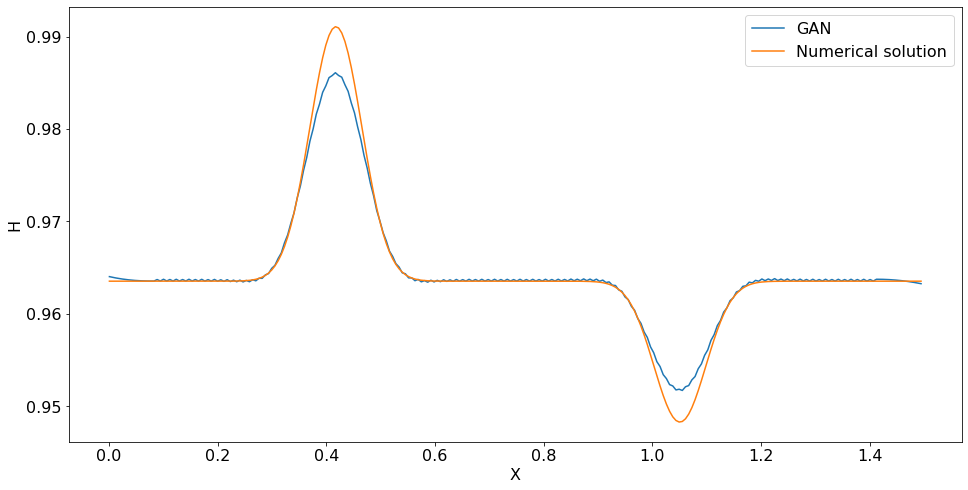

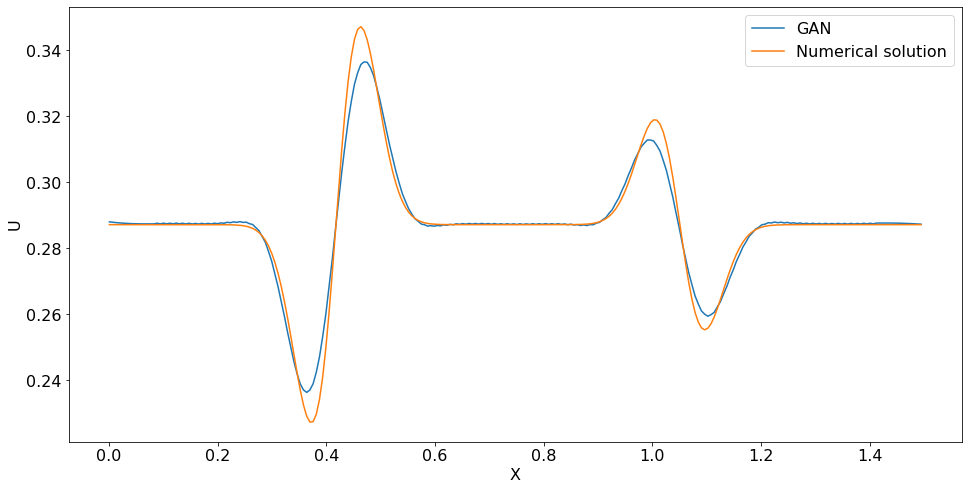

In [ ]:
font = {'size'   : 16}
plt.rc('font', **font)

fig=plt.figure(figsize=(16,8))
plt.plot(x1,savgh,label='GAN')
#plt.plot(x1,predh,label='GAN')
plt.plot(x1,tarh,label='Numerical solution')
plt.xlabel("X")
plt.ylabel("H")
plt.legend()
plt.savefig('GAN H.pdf')
plt.show()
print("  ")


fig=plt.figure(figsize=(16,8))
#plt.plot(x1,predu,label='GAN')
plt.plot(x1,savgu,label='GAN')
plt.plot(x1,taru,label='Numerical solution')
plt.xlabel("X")
plt.ylabel("U")
plt.legend()
plt.savefig('GAN U.pdf')
plt.show()

In [ ]:
#Error for H
mse(predh,tarh)

4.2186161990903925e-06

In [ ]:
#Error for H with filter applied
mse(savgh,tarh)

1.5374509849521243e-06

In [ ]:
#Error for U
mse(predu,taru)

4.27783941877651e-06

In [ ]:
#Error for U with filter applied
mse(savgu,taru)

1.185273569227625e-05